In [156]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import warnings
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import gc
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
# train_path = '/content/drive/My Drive/pa_task_data'
# 设置文件读取路径
train_path = '.'

In [0]:
df_data = pd.read_csv(os.path.join(train_path, 'pa-task-data.csv'))
df_data['type'] = 'train'
# df_data.to_pickle('/content/drive/My Drive/data.plk')

In [160]:
df_data.head()

,y,scr,diploma,home_ownership,car_ownership,location,constellation,grade,index,dk_cnt,tot_amnt,income,gender,occupation,dk_amnt(k),emp_length,dq_cnt,type
0,0,742,3,1,1,1,Aries,1,3,2,6,2,M,E,16,2,1,train
1,0,628,3,1,1,1,Capricom,4,9,1,1,1,M,D,66,2,1,train
2,0,763,4,1,0,1,Capricom,3,3,2,2,1,F,C,21,4,2,train
3,0,680,2,1,1,1,Virgo,3,3,1,1,3,F,E,71,1,1,train
4,1,436,1,1,1,1,Taurus,4,1,2,4,2,M,F,93,1,1,train


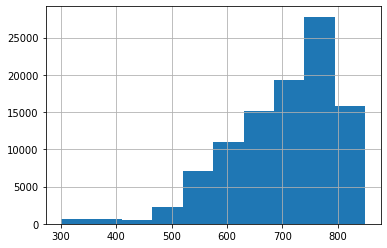

In [0]:
df_data['scr'].hist()

In [0]:
# 数据特征猜测： 学历
df_data['diploma'].value_counts()

1    40045
2    24862
3    20188
4     9950
5     4955
Name: diploma, dtype: int64

In [0]:
# 数据特征猜测： 是否拥有房产
df_data['home_ownership'].value_counts()

1    80731
0    19269
Name: home_ownership, dtype: int64

In [0]:
# 数据特征猜测： 是否拥有车
df_data['car_ownership'].value_counts()

1    60829
0    39171
Name: car_ownership, dtype: int64

In [0]:
df_data['location'].value_counts()

1    70757
0    29243
Name: location, dtype: int64

In [0]:
# 数据特征猜测： 星座
df_data['constellation'].value_counts()

# 牡羊座/白羊座 (3/21 - 4/20)的英文名：Aries
# 金牛座 (4/21 - 5/20)的英文名： Taurus
# 双子座 (5/21 - 6/21)的英文名： Gemini
# 巨蟹座 (6/22 - 7/22)的英文名： Cancer
# 狮子座 (7/23 - 8/22)的英文名： Leo
# 处女座/室女座 (8/23 - 9/22)的英文名： Virgo
# 天秤座 (9/23 - 10/22)的英文名： Libra
# 天蝎座 (10/23 - 11/21)的英文名： Scorpio
# 射手座/人马座 (11/22 - 12/21)的英文名： Sagittarius
# 魔羯座/山羊座 (12/22 - 1/19)的英文名： Capricorn
# 水瓶座 (1/20 - 2/18)的英文名： Aquarius
# 双鱼座 (2/19 - 3/20)的英文名： Pisces
# https://www.8s8s.com/xingzuo/xingzuozhishi/18624.html

Libra          8938
Virgo          8933
Capricom       8812
Taurus         8793
Aries          8391
Sagittarius    8321
Aquarius       8031
Pisces         8013
Scorpio        7979
Leo            7948
Gemini         7942
Cacer          7899
Name: constellation, dtype: int64

In [0]:
# 数据特征猜测： 用户等级（分段）
df_data['grade'].value_counts()

3    29239
4    24703
2    19448
5     9988
6     5136
1     4831
8     3533
7     3122
Name: grade, dtype: int64

In [0]:
df_data['index'].value_counts()

2     10102
7     10079
6     10060
8     10052
4     10045
10    10027
1     10012
9      9998
5      9871
3      9754
Name: index, dtype: int64

In [0]:
# 数据特征猜测： 贷款数量
df_data['dk_cnt'].value_counts()

2    51393
1    33740
3     8239
4     3044
6     2194
5     1390
Name: dk_cnt, dtype: int64

In [0]:
# 数据特征猜测： 总金额？
df_data['tot_amnt'].value_counts()

2    38539
1    33740
3    13687
4     6900
6     4343
5     2791
Name: tot_amnt, dtype: int64

In [0]:
# 数据特征猜测： 收入（分段）
df_data['income'].value_counts()

1    46209
2    19926
3    10942
4     7887
5     5953
6     4973
7     4110
Name: income, dtype: int64

In [0]:
# 数据特征猜测： 年龄
df_data['gender'].value_counts()

M    51379
F    48621
Name: gender, dtype: int64

In [0]:
# 数据特征猜测： 职业领域
df_data['occupation'].value_counts()

G    14392
F    14373
A    14311
E    14306
D    14271
B    14257
C    14090
Name: occupation, dtype: int64

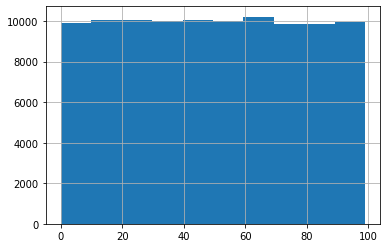

In [0]:
# 数据特征猜测： 贷款金额
df_data['dk_amnt(k)'].hist()

In [0]:
# 数据特征猜测： 工作时长
df_data['emp_length'].value_counts()

1    20146
4    20008
5    20006
3    19991
2    19849
Name: emp_length, dtype: int64

In [0]:
# 数据特征猜测： dq？数量
df_data['dq_cnt'].value_counts()

1    75520
5    14048
2     4368
3     4320
4     1744
Name: dq_cnt, dtype: int64

In [0]:
# label 分布
df_data['y'].value_counts()

0    96003
1     3997
Name: y, dtype: int64

In [0]:
# from feature_selector import FeatureSelector
# https://github.com/WillKoehrsen/feature-selector

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# fs = FeatureSelector(data = df_data.drop(columns = ['y', 'type']), labels = df_data['y'])

In [0]:
# fs.identify_missing(missing_threshold=0.01)

0 features with greater than 0.01 missing values.



In [0]:
# fs.identify_single_unique()

0 features with a single unique value.



In [0]:
# fs.identify_collinear(correlation_threshold=0.9)

0 features with a correlation magnitude greater than 0.90.



In [0]:
# fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
#                             n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[166]	valid_0's auc: 0.96828	valid_0's binary_logloss: 0.0698629
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	valid_0's auc: 0.964939	valid_0's binary_logloss: 0.074618
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	valid_0's auc: 0.955877	valid_0's binary_logloss: 0.0784346
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	valid_0's auc: 0.957627	valid_0's binary_logloss: 0.0761528
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[126]	valid_0's auc: 0.964634	valid_0's binary_logloss: 0.0724945
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[145]	valid_0's auc: 0.960566	valid_0's binary_log

In [0]:
df_feature = df_data.copy()

In [0]:
# df_feature.to_pickle('/content/drive/My Drive/feature.plk')

In [0]:
# df_feature = pd.read_pickle('/content/drive/My Drive/feature.plk')

In [0]:
for f in df_feature.select_dtypes('object'):
    if f not in ['date', 'type']:
        print(f)
        lbl = LabelEncoder()
        df_feature[f] = lbl.fit_transform(df_feature[f].astype(str))

In [0]:
df_feature['home_car_ownership'] = df_feature[['home_ownership', 'car_ownership']].apply(lambda x: x[0]+x[1]*2, axis=1)

In [0]:
df_feature['dk_dq_cnt_ratio'] = df_feature['dk_cnt'] / df_feature['dq_cnt']
df_feature['dk_dq_cnt_sum'] = df_feature['dk_cnt'] + df_feature['dq_cnt']

In [0]:
df_feature['dk_amnt_per_cnt'] = df_feature['dk_amnt(k)'] / df_feature['dk_cnt']

In [0]:
df_feature['dk_amnt_income_ratio'] = df_feature['dk_amnt(k)'] / df_feature['income']

In [0]:
df_feature['dk_amnt_emp_length_ratio'] = df_feature['dk_amnt(k)'] / df_feature['emp_length']

In [0]:
df_feature['income_occupation'] = df_feature[['income', 'occupation']].apply(lambda x: x[0]*7+x[1], axis=1)

In [0]:
# df_feature.to_pickle('/content/drive/My Drive/feature_1.plk')

In [0]:
# df_feature = pd.read_pickle('/content/drive/My Drive/feature_1.plk')

In [0]:
def group_base_mean(df_feature, group, base):
  group_array = df_feature[group].unique()
  f_dict = {}
  for group_element in group_array:
    f_dict[group_element] = df_feature[df_feature[group] == group_element][base].mean()
  df_feature[group+"_"+base+"_mean_diff"] = df_feature[[base, group]].apply(lambda x: x[0]-f_dict[x[1]], axis=1)

In [0]:
def group_base_median(df_feature, group, base):
  group_array = df_feature[group].unique()
  f_dict = {}
  for group_element in group_array:
    f_dict[group_element] = df_feature[df_feature[group] == group_element][base].median()
  df_feature[group+"_"+base+"_median_diff"] = df_feature[[base, group]].apply(lambda x: x[0]-f_dict[x[1]], axis=1)

In [0]:
def group_base_max(df_feature, group, base):
  group_array = df_feature[group].unique()
  f_dict = {}
  for group_element in group_array:
    f_dict[group_element] = df_feature[df_feature[group] == group_element][base].max()
  df_feature[group+"_"+base+"_max_diff"] = df_feature[[base, group]].apply(lambda x: x[0]-f_dict[x[1]], axis=1)

In [0]:
def group_base_min(df_feature, group, base):
  group_array = df_feature[group].unique()
  f_dict = {}
  for group_element in group_array:
    f_dict[group_element] = df_feature[df_feature[group] == group_element][base].min()
  df_feature[group+"_"+base+"_min_diff"] = df_feature[[base, group]].apply(lambda x: x[0]-f_dict[x[1]], axis=1)

In [0]:
for group in ['constellation', 'grade', 'index', 'occupation', 'diploma']:
  for base in ['scr', 'dk_cnt', 'tot_amnt', 'income', 'dk_amnt(k)', 'emp_length', 'dq_cnt']:
    for f in [group_base_mean, group_base_median, group_base_max, group_base_min]:
      f(df_feature, group, base)

In [0]:
# df_feature.to_pickle('/content/drive/My Drive/feature_2.plk')

In [0]:
# df_feature = pd.read_pickle('/content/drive/My Drive/feature_2.plk')

In [0]:
df_feature['scr_bin'] = pd.cut(df_feature['scr'], bins=5, labels=['scr_bin_0', 'scr_bin_1', 'scr_bin_2', 'scr_bin_3', 'scr_bin_4'])

In [0]:
for group in ['scr_bin']:
  for base in ['scr', 'diploma', 'constellation', 'grade', 'index', 'dk_cnt', 'tot_amnt', 'income', 'occupation', 'dk_amnt(k)', 'emp_length', 'dq_cnt']:
    for f in [group_base_mean, group_base_median, group_base_max, group_base_min]:
      f(df_feature, group, base)

In [0]:
df_feature['scr_bin'] = lbl.fit_transform(df_feature['scr_bin'])

In [0]:
# df_feature.to_pickle('/content/drive/My Drive/feature_3.plk')

In [0]:
# df_feature = pd.read_pickle('/content/drive/My Drive/feature_3.plk')

In [0]:
df_feature['dk_amnt(k)_bin'] = pd.cut(df_feature['dk_amnt(k)'], bins=10, labels=['dk_amnt(k)_bin_0', 'dk_amnt(k)_bin_1', 'dk_amnt(k)_bin_2', 'dk_amnt(k)_bin_3', 'dk_amnt(k)_bin_4', 'dk_amnt(k)_bin_5', 'dk_amnt(k)_bin_6', 'dk_amnt(k)_bin_7', 'dk_amnt(k)_bin_8', 'dk_amnt(k)_bin_9'])
for group in ['dk_amnt(k)_bin']:
  for base in ['scr', 'diploma', 'constellation', 'grade', 'index', 'dk_cnt', 'tot_amnt', 'income', 'occupation', 'dk_amnt(k)', 'emp_length', 'dq_cnt']:
    for f in [group_base_mean, group_base_median, group_base_max, group_base_min]:
      f(df_feature, group, base)

In [0]:
df_feature['dk_amnt(k)_bin'] = lbl.fit_transform(df_feature['dk_amnt(k)_bin'])

In [0]:
# df_feature.to_pickle('/content/drive/My Drive/feature_4.plk')

In [0]:
# df_feature = pd.read_pickle('/content/drive/My Drive/feature_4.plk')

In [0]:
label_0_idxs = df_feature.index[df_feature['y'] == 0].to_list()
label_1_idxs = df_feature.index[df_feature['y'] == 1].to_list()
test_size_0 = 19200
test_size_1 = 800
import random
random.seed(2020)
label_0_test_idxs = random.sample(label_0_idxs, test_size_0)
label_1_test_idxs = random.sample(label_1_idxs, test_size_1)

In [260]:
df_feature.head()

,y,scr,diploma,home_ownership,car_ownership,location,constellation,grade,index,dk_cnt,tot_amnt,income,gender,occupation,dk_amnt(k),emp_length,dq_cnt,type,home_car_ownership,dk_dq_cnt_ratio,dk_dq_cnt_sum,dk_amnt_per_cnt,dk_amnt_income_ratio,dk_amnt_emp_length_ratio,income_occupation,constellation_scr_mean_diff,constellation_scr_median_diff,constellation_scr_max_diff,constellation_scr_min_diff,constellation_dk_cnt_mean_diff,constellation_dk_cnt_median_diff,constellation_dk_cnt_max_diff,constellation_dk_cnt_min_diff,constellation_tot_amnt_mean_diff,constellation_tot_amnt_median_diff,constellation_tot_amnt_max_diff,constellation_tot_amnt_min_diff,constellation_income_mean_diff,constellation_income_median_diff,constellation_income_max_diff,constellation_income_min_diff,constellation_dk_amnt(k)_mean_diff,constellation_dk_amnt(k)_median_diff,constellation_dk_amnt(k)_max_diff,constellation_dk_amnt(k)_min_diff,constellation_emp_length_mean_diff,constellation_emp_length_median_diff,constellation_emp_length_max_diff,constellation_emp_length_min_diff,constellation_dq_cnt_mean_diff,constellation_dq_cnt_median_diff,constellation_dq_cnt_max_diff,constellation_dq_cnt_min_diff,grade_scr_mean_diff,grade_scr_median_diff,grade_scr_max_diff,grade_scr_min_diff,grade_dk_cnt_mean_diff,grade_dk_cnt_median_diff,grade_dk_cnt_max_diff,grade_dk_cnt_min_diff,grade_tot_amnt_mean_diff,grade_tot_amnt_median_diff,grade_tot_amnt_max_diff,grade_tot_amnt_min_diff,grade_income_mean_diff,grade_income_median_diff,grade_income_max_diff,grade_income_min_diff,grade_dk_amnt(k)_mean_diff,grade_dk_amnt(k)_median_diff,grade_dk_amnt(k)_max_diff,grade_dk_amnt(k)_min_diff,grade_emp_length_mean_diff,grade_emp_length_median_diff,grade_emp_length_max_diff,grade_emp_length_min_diff,grade_dq_cnt_mean_diff,grade_dq_cnt_median_diff,grade_dq_cnt_max_diff,grade_dq_cnt_min_diff,index_scr_mean_diff,index_scr_median_diff,index_scr_max_diff,index_scr_min_diff,index_dk_cnt_mean_diff,index_dk_cnt_median_diff,index_dk_cnt_max_diff,index_dk_cnt_min_diff,index_tot_amnt_mean_diff,index_tot_amnt_median_diff,index_tot_amnt_max_diff,index_tot_amnt_min_diff,index_income_mean_diff,index_income_median_diff,index_income_max_diff,index_income_min_diff,index_dk_amnt(k)_mean_diff,index_dk_amnt(k)_median_diff,index_dk_amnt(k)_max_diff,index_dk_amnt(k)_min_diff,index_emp_length_mean_diff,index_emp_length_median_diff,index_emp_length_max_diff,index_emp_length_min_diff,index_dq_cnt_mean_diff,index_dq_cnt_median_diff,index_dq_cnt_max_diff,index_dq_cnt_min_diff,occupation_scr_mean_diff,occupation_scr_median_diff,occupation_scr_max_diff,occupation_scr_min_diff,occupation_dk_cnt_mean_diff,occupation_dk_cnt_median_diff,occupation_dk_cnt_max_diff,occupation_dk_cnt_min_diff,occupation_tot_amnt_mean_diff,occupation_tot_amnt_median_diff,occupation_tot_amnt_max_diff,occupation_tot_amnt_min_diff,occupation_income_mean_diff,occupation_income_median_diff,occupation_income_max_diff,occupation_income_min_diff,occupation_dk_amnt(k)_mean_diff,occupation_dk_amnt(k)_median_diff,occupation_dk_amnt(k)_max_diff,occupation_dk_amnt(k)_min_diff,occupation_emp_length_mean_diff,occupation_emp_length_median_diff,occupation_emp_length_max_diff,occupation_emp_length_min_diff,occupation_dq_cnt_mean_diff,occupation_dq_cnt_median_diff,occupation_dq_cnt_max_diff,occupation_dq_cnt_min_diff,diploma_scr_mean_diff,diploma_scr_median_diff,diploma_scr_max_diff,diploma_scr_min_diff,diploma_dk_cnt_mean_diff,diploma_dk_cnt_median_diff,diploma_dk_cnt_max_diff,diploma_dk_cnt_min_diff,diploma_tot_amnt_mean_diff,diploma_tot_amnt_median_diff,diploma_tot_amnt_max_diff,diploma_tot_amnt_min_diff,diploma_income_mean_diff,diploma_income_median_diff,diploma_income_max_diff,diploma_income_min_diff,diploma_dk_amnt(k)_mean_diff,diploma_dk_amnt(k)_median_diff,diploma_dk_amnt(k)_max_diff,diploma_dk_amnt(k)_min_diff,diploma_emp_length_mean_diff,diploma_emp_length_median_diff,diploma_emp_length_max_diff,diploma_emp_length_min_diff,diploma_dq_cnt_mean_diff,diploma_dq_c

In [0]:
for f in df_feature.select_dtypes('object'):
    if f not in ['date', 'type']:
        print(f)
        lbl = LabelEncoder()
        df_feature[f] = lbl.fit_transform(df_feature[f].astype(str))

In [0]:
for idx in label_0_test_idxs + label_1_test_idxs:
  df_feature.iloc[idx, df_feature.columns.get_loc('type')] = 'test'

In [0]:
seed = 2020
df_train = df_feature[df_feature['type'] == 'train'].copy()
df_train = shuffle(df_train, random_state=seed)

In [0]:
delete_list = []

In [0]:
ycol = 'y'

In [0]:
feature_names = list(
    filter(lambda x: x not in ([ycol, 'type'] + delete_list), df_train.columns))

In [0]:
model = lgb.LGBMClassifier(num_leaves=64,
                           max_depth=10,
                           learning_rate=0.1,
                           n_estimators=10000000,
                           subsample=0.8,
                           feature_fraction=0.8,
                           reg_alpha=0.5,
                           reg_lambda=0.5,
                           random_state=seed,
                           metric=None
                           )

In [0]:
# # SMOTE 算法处理样本不平衡
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=2020)
# X_res, y_res = sm.fit_resample(df_train[feature_names], df_train[ycol])
# df_train = pd.DataFrame(X_res)
# df_train.columns = feature_names
# df_train[ycol] = y_res
# df_train = shuffle(df_train, random_state=seed)

In [254]:
oof = []
df_importance_list = []
prediction_list = []
df_test = df_feature[df_feature['type'] == 'test'].copy()
prediction = pd.DataFrame([0 for i in range(len(df_test))])
prediction.columns = ['target']

prediction_train_all_list = []
df_train_all = df_feature.copy()
prediction_train_all = pd.DataFrame([0 for i in range(len(df_train_all))])
prediction_train_all.columns = ['target']

kfold = KFold(n_splits=10)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]
    
    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=500,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(
        X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof = df_train.iloc[val_idx][[ycol]].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)

    pred_test = lgb_model.predict_proba(
        df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['target'] += pred_test / 10
    prediction_list.append(pred_test.copy())

    pred_train_all = lgb_model.predict_proba(
        df_train_all[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction_train_all['target'] += pred_train_all / 10
    prediction_train_all_list.append(pred_train_all.copy())


    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[52]	train's auc: 0.989975	valid's auc: 0.96635

Fold_2 Training ================================

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[45]	train's auc: 0.988565	valid's auc: 0.962187

Fold_3 Training ================================

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[57]	train's auc: 0.991232	valid's auc: 0.95389

Fold_4 Training ================================

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[53]	train's auc: 0.989874	valid's auc: 0.975857

Fold_5 Training ================================

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[124]	train's auc: 0.998075	valid's auc: 0.965862

Fold_6 Training

In [0]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()
df_importance

In [0]:
df_oof_train = pd.concat(oof, sort=False)

In [257]:
df_oof_train.head()

,y,pred
58341,0,0.002080
77332,0,0.006443
95323,0,0.000686
58237,0,0.002078
62736,0,0.002229


In [0]:
def pre2label(pred_list, threshold):
  return [0 if pred < threshold else 1 for pred in pred_list]

In [0]:
def score(labels, pres, threshold=0.5):
  print("roc_auc_score: "+str(roc_auc_score(labels, pres)))
  print("accuracy_score: "+str(accuracy_score(labels, pre2label(pres, threshold))))
  print("recall_score: "+str(recall_score(labels, pre2label(pres, threshold))))
  print("precision_score: "+str(precision_score(labels, pre2label(pres, threshold))))
  print("f1_score: "+str(f1_score(labels, pre2label(pres, threshold))))

# After Data mining (dk amnt Group)

In [43]:
score(df_oof_train['y'], df_oof_train['pred'], 0.5)

roc_auc_score: 0.9626019212550064
accuracy_score: 0.9748875
recall_score: 0.529246168282765
precision_score: 0.7704918032786885
f1_score: 0.6274800667531986


In [45]:
score(df_oof_train['y'], df_oof_train['pred'], 0.3)

roc_auc_score: 0.9626019212550064
accuracy_score: 0.9721875
recall_score: 0.6312167657178605
precision_score: 0.6586161879895561
f1_score: 0.6446254591918222


In [48]:
score(df_test[ycol], prediction['target'], 0.5)

roc_auc_score: 0.9621425130208333
accuracy_score: 0.9752
recall_score: 0.52875
precision_score: 0.7804428044280443
f1_score: 0.6304023845007451


In [50]:
score(df_test[ycol], prediction['target'], 0.3)

roc_auc_score: 0.9621425130208333
accuracy_score: 0.97235
recall_score: 0.6325
precision_score: 0.661437908496732
f1_score: 0.6466453674121405


In [258]:
score(df_train_all[ycol], prediction_train_all['target'], 0.5)

roc_auc_score: 0.9882003885443795
accuracy_score: 0.9826
recall_score: 0.6452339254440831
precision_score: 0.8890037917959325
f1_score: 0.7477529718759061


In [259]:
score(df_train_all[ycol], prediction_train_all['target'], 0.3)

roc_auc_score: 0.9882003885443795
accuracy_score: 0.98264
recall_score: 0.7823367525644234
precision_score: 0.7831204608064112
f1_score: 0.7827284105131415


# After Data mining (scr Group)

In [86]:
score(df_oof_train['y'], df_oof_train['pred'], 0.5)

roc_auc_score: 0.962000514207119
accuracy_score: 0.9755125
recall_score: 0.5386299655927432
precision_score: 0.7805983680870353
f1_score: 0.637423653525819


In [88]:
score(df_oof_train['y'], df_oof_train['pred'], 0.3)

roc_auc_score: 0.962000514207119
accuracy_score: 0.9724375
recall_score: 0.633406318423522
precision_score: 0.6621975147155004
f1_score: 0.6474820143884892


In [90]:
score(df_test[ycol], prediction['target'], 0.5)

roc_auc_score: 0.9618130859374998
accuracy_score: 0.97565
recall_score: 0.53125
precision_score: 0.7914338919925512
f1_score: 0.6357516828721017


In [92]:
score(df_test[ycol], prediction['target'], 0.3)

roc_auc_score: 0.9618130859374998
accuracy_score: 0.97225
recall_score: 0.6325
precision_score: 0.6597131681877445
f1_score: 0.6458200382897256


In [244]:
score(df_train_all[ycol], prediction_train_all['target'], 0.5)

roc_auc_score: 0.9874500288932938
accuracy_score: 0.98202
recall_score: 0.6314736052039029
precision_score: 0.8859248859248859
f1_score: 0.7373648846041485


In [245]:
score(df_train_all[ycol], prediction_train_all['target'], 0.3)

roc_auc_score: 0.9874500288932938
accuracy_score: 0.98189
recall_score: 0.7718288716537403
precision_score: 0.7743473895582329
f1_score: 0.7730860794386667


# After Data mining (Basic Group)



In [106]:
score(df_oof_train['y'], df_oof_train['pred'], 0.5)

roc_auc_score: 0.9623005151955559
accuracy_score: 0.975175
recall_score: 0.5351892399124178
precision_score: 0.7738579828132067
f1_score: 0.632766272189349


In [107]:
score(df_oof_train['y'], df_oof_train['pred'], 0.3)

roc_auc_score: 0.9623005151955559
accuracy_score: 0.9725
recall_score: 0.6362214576165155
precision_score: 0.6623249755779876
f1_score: 0.6490108487555839


In [108]:
score(df_test[ycol], prediction['target'], 0.5)

roc_auc_score: 0.9621179687500001
accuracy_score: 0.97535
recall_score: 0.53
precision_score: 0.7837338262476895
f1_score: 0.6323639075316928


In [109]:
score(df_test[ycol], prediction['target'], 0.3)

roc_auc_score: 0.9621179687500001
accuracy_score: 0.97255
recall_score: 0.6375
precision_score: 0.6631989596879063
f1_score: 0.6500956022944551


In [229]:
score(df_train_all[ycol], prediction_train_all['target'], 0.5)

roc_auc_score: 0.9875234775195488
accuracy_score: 0.98197
recall_score: 0.6307230422817113
precision_score: 0.8851825842696629
f1_score: 0.7365960555149744


In [230]:
score(df_train_all[ycol], prediction_train_all['target'], 0.3)

roc_auc_score: 0.9875234775195488
accuracy_score: 0.9817
recall_score: 0.7713284963722792
precision_score: 0.770942735683921
f1_score: 0.7711355677838919


# Basic Features

In [151]:
score(df_oof_train['y'], df_oof_train['pred'], 0.5)

roc_auc_score: 0.9628956910589479
accuracy_score: 0.9755125
recall_score: 0.5361276196434157
precision_score: 0.782648401826484
f1_score: 0.6363467607202524


In [152]:
score(df_oof_train['y'], df_oof_train['pred'], 0.3)

roc_auc_score: 0.9628956910589479
accuracy_score: 0.9723875
recall_score: 0.6249609008445418
precision_score: 0.6642287234042553
f1_score: 0.6439967767929091


In [153]:
score(df_test[ycol], prediction['target'], 0.5)

roc_auc_score: 0.9621458984375001
accuracy_score: 0.9752
recall_score: 0.5225
precision_score: 0.7857142857142857
f1_score: 0.6276276276276276


In [154]:
score(df_test[ycol], prediction['target'], 0.3)

roc_auc_score: 0.9621458984375001
accuracy_score: 0.97325
recall_score: 0.64
precision_score: 0.6745718050065876
f1_score: 0.6568313021167416


In [215]:
score(df_train_all[ycol], prediction_train_all['target'], 0.5)

roc_auc_score: 0.9849011994665718
accuracy_score: 0.98038
recall_score: 0.6014510883162372
precision_score: 0.86693112152903
f1_score: 0.710192023633678


In [216]:
score(df_train_all[ycol], prediction_train_all['target'], 0.3)

roc_auc_score: 0.9849011994665718
accuracy_score: 0.97992
recall_score: 0.7380535401551164
precision_score: 0.7542827921247762
f1_score: 0.7460799190692969


# Baseline

In [122]:
score(df_oof_train['y'], df_oof_train['pred'], 0.5)

roc_auc_score: 0.9631984268450245
accuracy_score: 0.9750125
recall_score: 0.5333124804504222
precision_score: 0.7707956600361664
f1_score: 0.6304307635422444


In [123]:
score(df_oof_train['y'], df_oof_train['pred'], 0.3)

roc_auc_score: 0.9631984268450245
accuracy_score: 0.972175
recall_score: 0.633406318423522
precision_score: 0.6576810652809354
f1_score: 0.6453154875717017


In [124]:
score(df_test[ycol], prediction['target'], 0.5)

roc_auc_score: 0.9625846354166665
accuracy_score: 0.9754
recall_score: 0.52875
precision_score: 0.7862453531598513
f1_score: 0.6322869955156951


In [125]:
score(df_test[ycol], prediction['target'], 0.3)

roc_auc_score: 0.9625846354166665
accuracy_score: 0.97285
recall_score: 0.6475
precision_score: 0.6649550706033376
f1_score: 0.6561114629512349


In [200]:
score(df_train_all[ycol], prediction_train_all['target'], 0.5)

roc_auc_score: 0.9822388431272205
accuracy_score: 0.97952
recall_score: 0.5884413309982487
precision_score: 0.8537205081669691
f1_score: 0.6966824644549764


In [201]:
score(df_train_all[ycol], prediction_train_all['target'], 0.3)

roc_auc_score: 0.9822388431272205
accuracy_score: 0.97841
recall_score: 0.7200400300225169
precision_score: 0.734558448187851
f1_score: 0.7272267845862286


# Results

In [0]:
res = [
       [0.9631984268450245, 0.972175, 0.6453154875717017, 0.9625846354166665, 0.97285, 0.6561114629512349, 0.9822388431272205, 0.97841, 0.7272267845862286],
       [0.9628956910589479, 0.9723875, 0.6439967767929091, 0.9621458984375001, 0.97325, 0.6568313021167416, 0.9849011994665718, 0.97992, 0.7460799190692969],
       [0.9623005151955559, 0.9725, 0.6490108487555839, 0.9621179687500001, 0.97255, 0.6500956022944551, 0.9875234775195488, 0.9817, 0.7711355677838919],
       [0.962000514207119, 0.9724375, 0.6474820143884892, 0.9618130859374998, 0.97225, 0.6458200382897256, 0.9874500288932938, 0.98189, 0.7730860794386667],
       [0.9626019212550064, 0.9721875, 0.6446254591918222, 0.9621425130208333, 0.97235, 0.6466453674121405, 0.9882003885443795, 0.98264, 0.7827284105131415]
]

In [0]:
import matplotlib.pyplot as plt

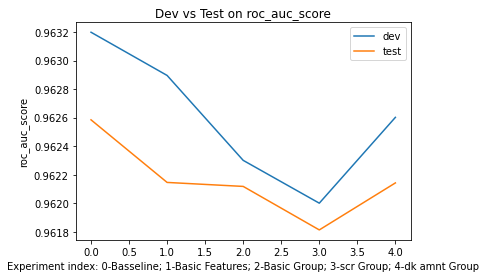

In [291]:
plt.plot([row[0] for row in res], label='dev')
plt.plot([row[3] for row in res], label='test')
plt.xlabel('Experiment index: 0-Basseline; 1-Basic Features; 2-Basic Group; 3-scr Group; 4-dk amnt Group')
plt.ylabel('roc_auc_score')
plt.title('Dev vs Test on roc_auc_score')
plt.legend()

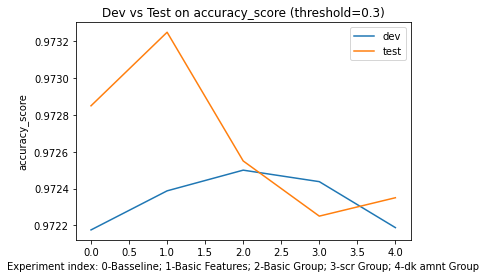

In [293]:
plt.plot([row[1] for row in res], label='dev')
plt.plot([row[4] for row in res], label='test')
plt.xlabel('Experiment index: 0-Basseline; 1-Basic Features; 2-Basic Group; 3-scr Group; 4-dk amnt Group')
plt.ylabel('accuracy_score')
plt.title('Dev vs Test on accuracy_score (threshold=0.3)')
plt.legend()

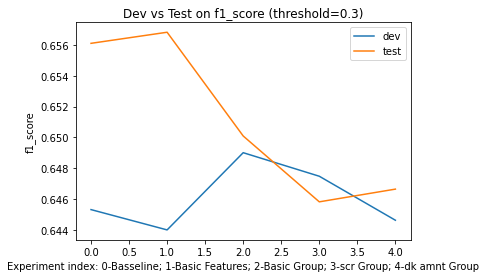

In [294]:
plt.plot([row[2] for row in res], label='dev')
plt.plot([row[5] for row in res], label='test')
plt.xlabel('Experiment index: 0-Basseline; 1-Basic Features; 2-Basic Group; 3-scr Group; 4-dk amnt Group')
plt.ylabel('f1_score')
plt.title('Dev vs Test on f1_score (threshold=0.3)')
plt.legend()

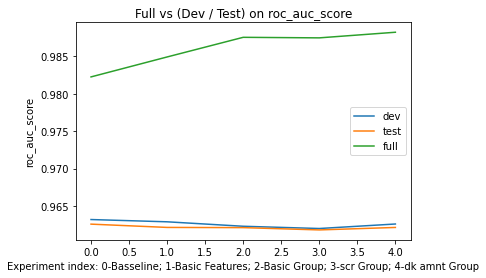

In [295]:
plt.plot([row[0] for row in res], label='dev')
plt.plot([row[3] for row in res], label='test')
plt.plot([row[6] for row in res], label='full')
plt.xlabel('Experiment index: 0-Basseline; 1-Basic Features; 2-Basic Group; 3-scr Group; 4-dk amnt Group')
plt.ylabel('roc_auc_score')
plt.title('Full vs (Dev / Test) on roc_auc_score')
plt.legend()

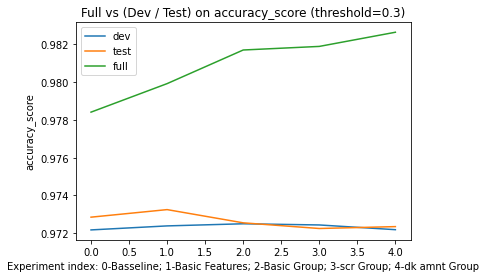

In [298]:
plt.plot([row[1] for row in res], label='dev')
plt.plot([row[4] for row in res], label='test')
plt.plot([row[7] for row in res], label='full')
plt.xlabel('Experiment index: 0-Basseline; 1-Basic Features; 2-Basic Group; 3-scr Group; 4-dk amnt Group')
plt.ylabel('accuracy_score')
plt.title('Full vs (Dev / Test) on accuracy_score (threshold=0.3)')
plt.legend()

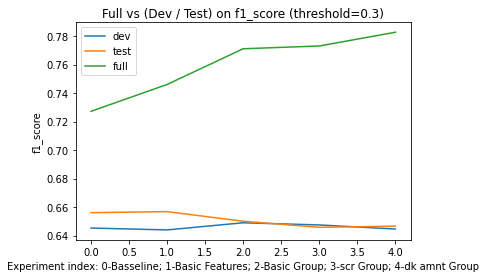

In [296]:
plt.plot([row[2] for row in res], label='dev')
plt.plot([row[5] for row in res], label='test')
plt.plot([row[8] for row in res], label='full')
plt.xlabel('Experiment index: 0-Basseline; 1-Basic Features; 2-Basic Group; 3-scr Group; 4-dk amnt Group')
plt.ylabel('f1_score')
plt.title('Full vs (Dev / Test) on f1_score (threshold=0.3)')
plt.legend()